#  Import dependencies


In [56]:
import os 
import time
from imageio import imread
import cv2

import tensorflow as tf

In [57]:
from unet_pp import Xnet
from unet_pp.data import *
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-0"

## CPU Placement

In [ ]:
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

GPU = False
CPU = True

num_cores = 8

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 10
    num_GPU = 1

config = tf.ConfigProto(device_count = {'CPU' : num_CPU,
                                        'GPU' : num_GPU})
config.intra_op_parallelism_threads = num_cores
config.inter_op_parallelism_threads = num_cores
config.allow_soft_placement = True
sess = tf.Session(config=config)
set_session(sess)

## GPU Placement

In [3]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Config

In [4]:
# set the root path of train data
#data_path = r'./data' ## windows
data_path = "data"
# train image path
images_folder = 'train_images'
# train mask path
labels_folder = 'train_labels'

# val image path
valid_images_folder = 'val_images'
# val mask path
valid_labels_folder = 'val_labels'


# model save path
cache_path = data_path + '/model_data'

save_model_filename = 'ct_angel'

batch_size = 2
epochs = 2

img_size = 512
train_samples = 4   # change according to actual
valid_samples = 2   # change according to actual
# input_size
input_size = (img_size, img_size, 3)

# Data augmentation

In [ ]:
# train data
train_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

trainGene = trainGenerator(batch_size, data_path, images_folder, labels_folder, train_gen_args,
                        image_color_mode="rgb", mask_color_mode="grayscale",
                        target_size=(img_size,img_size))

# valid data
valid_gen_args = dict(fill_mode='nearest')

validGene = trainGenerator(batch_size, data_path, valid_images_folder, valid_labels_folder, valid_gen_args,
                        image_color_mode="rgb", mask_color_mode="grayscale",
                        target_size=(img_size,img_size))

# Train

In [ ]:
# model save path
if not os.path.exists(cache_path):
    os.mkdir(cache_path)

In [ ]:
# create unet_pp model and set params

model = Xnet(input_shape=input_size, backbone_name='resnet50', encoder_weights='imagenet', decoder_block_type='transpose')

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

now = time.strftime("%y-%m-%d_%H_%M", time.localtime(time.time()))

model_name = save_model_filename + "_" + now + '_{epoch:02d}-{val_acc:.3f}.hdf5'
abs_model_name = os.path.join(cache_path, model_name)

model_checkpoint = ModelCheckpoint(abs_model_name, monitor='val_loss', verbose=2, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
callbacks = [early_stop, model_checkpoint]

In [ ]:
# begin train
history = model.fit_generator(trainGene, steps_per_epoch=train_samples // batch_size, epochs=epochs, 
                    validation_data=validGene, validation_steps=valid_samples // batch_size, 
                    callbacks=callbacks)

# Predict

In [58]:
# load model weights
# download model weights 
# link：https://pan.baidu.com/s/1zwDztKY0zSvhtBE48J-2vw 
# extraction code：zide

model_file_name = 'ct_angel_lung_weights.hdf5'
model_path = os.path.join(cache_path, model_file_name)

model = Xnet(input_shape=input_size, backbone_name='resnet50', encoder_weights='imagenet', decoder_block_type='transpose')

print('load: ', model_path)
model.load_weights(model_path)

load:  data/model_data/ct_angel_lung_weights.hdf5


In [59]:
#model.save('../../ct-angel-web-app/model/ct_angel_lung_model.h5')

In [60]:
# predict and save image
# test_img_path = data_path + r'\test_images'
test_img_path = os.path.join(data_path, "test_images")
# test_label_path = data_path + r'\test_labels'
test_label_path = os.path.join(data_path, "test_labels")
# result_path = data_path + r'\prd_result'
result_path = os.path.join(data_path, "prd_result")
if not os.path.exists(result_path):
    os.mkdir(result_path)
    
test_files = os.listdir(test_img_path)
predict_area_num = 3

In [61]:
def takeLength(elem):
    return len(elem)

In [62]:
test_files

['test_file_0.jpg', '.ipynb_checkpoints']

## Slice-wise

1/1 [==============================] - 2s 2s/step
Unet++ Result Image


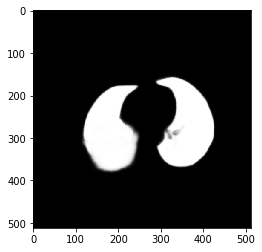

Segmentation Mask


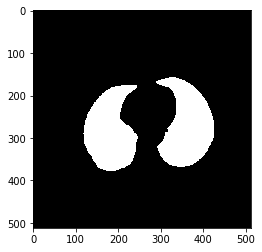

ValueError: Could not find a format to read the specified file in mode 'i'

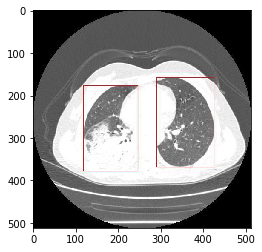

In [63]:
import time
import matplotlib.pyplot as plt

start = time.time()
for file in test_files:
    fpath, fname = os.path.split(file)

    out_fname = os.path.join(result_path, fname)
    src_img = io.imread(os.path.join(test_img_path, file))
    img = src_img
    
    img = trans.resize(img,(img_size, img_size))
    
    # img from (512, 512, 3) trans to (1, 512, 512, 3)
    img = np.reshape(img,(1,)+img.shape)


    # predict
    results = model.predict(np.array(img),verbose=1)
    
    gray_img = results[0][:,:,0]
    
    print("Unet++ Result Image")
    plt.imshow(gray_img, cmap="gray")
    plt.show()
    
    # to gray
    bw_heatmap = np.uint8(255 * gray_img)
    ## Thresholding greyscale values
    ## Everything above an intensity of 127 is white
    ## Everything below is black
    bw_heatmap[bw_heatmap <= 127] = 0
    bw_heatmap[bw_heatmap > 127] = 255
    
    print("Segmentation Mask")
    plt.imshow(bw_heatmap, cmap="gray")
    plt.show()
    
    _, ai_ctrs, _ = cv2.findContours(bw_heatmap.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ai_ctrs.sort(key=takeLength, reverse=True)

    # choose the bigger 
    ai_ctrs = ai_ctrs[:predict_area_num]
    
    # draw box
    for c in ai_ctrs:        
        # find bounding box coordinates
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(src_img, (x,y), (x+w, y+h), (255, 0, 0), 1)
        
        
    # save result image
    io.imsave(out_fname, src_img)
    
    result_img = plt.imread(out_fname)
    plt.imshow(result_img)
    
done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)  

## Batch-wise

In [ ]:
#from glob import glob

BATCH_SIZE = 16

start = time.time()
filenames = glob(os.path.join(test_img_path, "*.jpg"))


for batch in xrange(BATCH_SIZE):
    print(batch)


In [55]:
for file in test_files:
    fpath, fname = os.path.split(file)

    out_fname = os.path.join(result_path, fname)

    
    src_img = imread(os.path.join(test_img_path, file))
    img = src_img
    
    img = trans.resize(img,(img_size, img_size))
    
    # img from (512, 512, 3) trans to (1, 512, 512, 3)
    img = np.reshape(img,(1,)+img.shape)

    # predict
    results = model.predict(np.array(img), verbose=1)

    gray_img = results[0][:, :, 0]

    # to gray
    bw_heatmap = np.uint8(255 * gray_img)
    bw_heatmap[bw_heatmap <= 127] = 0
    bw_heatmap[bw_heatmap > 127] = 255
    _, ai_ctrs, _ = cv2.findContours(bw_heatmap.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ai_ctrs.sort(key=takeLength, reverse=True)

    # choose the bigger 
    ai_ctrs = ai_ctrs[:predict_area_num]

    # draw box
    for c in ai_ctrs:        
        # find bounding box coordinates
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(src_img, (x,y), (x+w, y+h), (255, 0, 0), 1)
        
    # save result image
    io.imsave(out_fname, src_img)
    
done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)  

1/1 [==============================] - 0s 69ms/step
<class 'imageio.core.util.Array'>
Elapsed:  1009.4473264217377


In [ ]:
from shutil import copyfile
for i in range(0, 512):
    src = fname
    dst = os.path.join(test_img_path, "test_file_%i.jpg"%i)
    copyfile(src, dst)